In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import requests
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

output = widgets.Output()

from random import randrange
import warnings
warnings.filterwarnings('ignore')

In [21]:
class ContentManager(object):
    x_column_list = [ "X%d"%i for i in range(6, 11) ]
    y_column_maplist = {
        "Y1 - 氧 O2": 'Y1',
        "Y2 - 二氧化碳 CO2": 'Y2',
        "Y3 - 一氧化碳 CO_6% O2": 'Y3',
        "Y4 - 氮氧化合物 NOx_6% O2": 'Y4',
        "Y5 - 二氧化硫 SO2": "Y5"
    }
    y_column_name_maplist = {
        'Y1': "Y1 - 氧 O2" ,
        'Y2': "Y2 - 二氧化碳 CO2" ,
        'Y3': "Y3 - 一氧化碳 CO_6% O2" ,
        'Y4': "Y4 - 氮氧化合物 NOx_6% O2" ,
        "Y5": "Y5 - 二氧化硫 SO2"
    }

    def __init__(self, origin_data):
        ## 原始資料
        self.origin_data = origin_data.copy()
        #self.data = origin_data.copy()
        
        ## 測試期間
        self.test_period = 30
        
        ## 移動窗格大小
        self.moving_window_size = 360
        
        ## y 欄位
        self.y_column = 'Y3'
        
        ## 決策樹深度參數
        self.tree_max_depth = 3
        
        ## 參數初始化
        self.setHyperParameter()
        
        self._model = None
        
        ## 畫圖的變數
        self._fig = None
        self._ax1 = None
        self._ax2 = None
        
    def setHyperParameter(self):
        data = self.origin_data.copy()

        ##模型輸入特徵lag處理
        self.feature_col = []
        for log in range(self.moving_window_size+1):
            ## y 
            if log>0:
                _y_log = "%s_%d"%(self.y_column, log)
                data[_y_log] = data[self.y_column].shift(log)
                self.feature_col.append(_y_log)
            
            for x_column in self.x_column_list:
                _x_log = "%s_%d"%(x_column, log)
                data[_x_log] = data[x_column].shift(log)
                self.feature_col.append(_x_log)
                
        data = data.dropna()
        self.train_data = data.iloc[:-self.test_period,:]
        self.test_data = data.iloc[-self.test_period:,:]
        #print('Training index : ',  train_data.index[0], "~", train_data.index[-1])
        #print('Testing  index : ',  test_data.index[0], "~", test_data.index[-1])
        
        self.train_y = self.train_data[[self.y_column]]
        self.train_x = self.train_data[self.feature_col]
        self.test_y  = self.test_data[[self.y_column]]
        self.test_x  = self.test_data[self.feature_col]
        
    def testPeriodOnChange(self, change):
        if change['name'] == 'value':
            self.test_period = change['new']
            
    def movingWindowSizeOnChange(self, change):
        if change['name'] == 'value':
            self.moving_window_size = change['new']
            
    def treeMaxDepthOnChange(self, change):
        if change['name'] == 'value':
            self.tree_max_depth = change['new']

    def yColumnOnChange(self, change):
        if change['name'] == 'value':
            self.y_column = self.y_column_maplist[change['new']]
            
    def dataProcessingButtonOnClick(self, button_event):
        self.setHyperParameter()
        
    def modelPredictionButtonOnClick(self, button_event):
        self._model = DecisionTreeRegressor(max_depth=self.tree_max_depth)
        self._model.fit(
            self.train_x.values, 
            self.train_y.values
        )
        
    def showPredictionWidgetOnChange(self, change):
        if change['name'] == 'value':
            self.plotData(change['new'])
        
    def plotData(self, show_pred=True):
        display_data = self.test_data
        

        self._fig, [self._ax1, self._ax2] = plt.subplots(2, 1, sharex=True, figsize=(20,10))
        self._ax1.set_title("X")
        for i in range(6, 11):
            self._ax1.plot(np.arange(display_data.shape[0]), display_data['X%d'%i], label = 'X%d'%i)  
        self._ax1.grid(True)
        self._ax1.legend()

        self._ax2.set_title(self.y_column)
        self._ax2.plot(np.arange(display_data.shape[0]), 
                 display_data[self.y_column], 
                 color = 'b', 
                 label = self.y_column,
                 marker='o', 
                 linestyle='--')
        if show_pred and not self._model is None:
            test_prediction = self._model.predict(self.test_x.values)
            self._ax2.plot(np.arange(display_data.shape[0]), 
                     test_prediction, 
                     color = 'red', 
                     label=f'{self.tree_max_depth}-pred', 
                     marker='o', 
                     linestyle='--')
        self._ax2.grid(True)
        self._ax2.legend()
        self._fig.show()

    def showFeatureImportances(self, top_k=10):
        feature_importances = pd.DataFrame(
            self._model.feature_importances_, 
            index=self.train_x.columns, 
            columns=['value']
        ).sort_values('value', ascending=False)
        
        print(f'前{top_k}個重要的特徵')
        plt.figure(figsize=(10,6))
        for feature_name in feature_importances.head(top_k).index.values:
            feature_value = feature_importances.loc[feature_name, 'value']
            plt.bar(feature_name, feature_value)
    
    def showTree(self):
        if self.tree_max_depth<5:
            plt.figure(figsize=(40,20))
            _ = tree.plot_tree(
                self._model, 
                feature_names=self.train_x.columns,
                filled=True
            )
        else:
            print('圖太大了，畫不出來')
            

In [35]:
class DisplayManager(object):
    def __init__(self, output, content_manager):
        self._output = output
        self._content_manager = content_manager
        
        self._test_period_widget = widgets.IntText(
            value=content_manager.test_period,
            disabled=False
        )
        self._moving_window_size_widget = widgets.IntText(
            value=content_manager.moving_window_size,
            disabled=False
        )
        self._y_column_widget = widgets.RadioButtons(
            options=list(content_manager.y_column_maplist.keys()),
            value=content_manager.y_column_name_maplist[content_manager.y_column],
            layout={'width': 'max-content'}
        )
        self._data_processing_button = widgets.Button(description="參數確認")
        self._model_prediction_button = widgets.Button(description="模型預測")
        
        self._tree_max_depth_widget = widgets.IntText(
            value=content_manager.tree_max_depth,
            disabled=False
        )
        
        self._show_prediction_widget = widgets.Checkbox(
            value=False,
            description='模型預測資料',
            disabled=False,
            indent=False
        )
        
        ## observe event
        self._test_period_widget.observe(content_manager.testPeriodOnChange)
        self._moving_window_size_widget.observe(content_manager.movingWindowSizeOnChange)
        self._y_column_widget.observe(content_manager.yColumnOnChange)
        self._tree_max_depth_widget.observe(content_manager.treeMaxDepthOnChange)
        
        self._data_processing_button.on_click(content_manager.dataProcessingButtonOnClick)
        
        self._model_prediction_button.on_click(content_manager.modelPredictionButtonOnClick)
        self._show_prediction_widget.observe(self._showPredictionWidgetOnChange)
    
    def _testPeriodOnChange(self, change):
        if change['name'] == 'value':
            self._content_manager.content_manager(change)
        
    def _showPredictionWidgetOnChange(self, change):
        if change['name'] == 'value':
            clear_output()
            self._content_manager.showPredictionWidgetOnChange(change)
            self.displayPreditionDashboard()
        
        
        
    def displayHyperParamDashboard(self):
        display(widgets.Box([
            widgets.Label(value='想預測幾筆：'),
                self._test_period_widget,
            widgets.Label(value='要考慮多少資料：'),
                self._moving_window_size_widget
        ]), self._output)
        display(widgets.Box(
            [
                widgets.Label(value='想預測的欄位：'),
                self._y_column_widget
            ]
        ), self._output)
        display(widgets.Box(
            [
                widgets.Label(value='模型參數：'),
                self._tree_max_depth_widget
            ]
        ), self._output)
        display(self._data_processing_button, self._output)
        
    def displayTrainModel(self):
        display(self._model_prediction_button, self._output)
        
    def displayPreditionDashboard(self):
        display(widgets.Box([self._show_prediction_widget]), self._output)
        #self._content_manager.plotData(self._show_prediction_widget.value)
        


origin_data = pd.read_csv(
    io.StringIO(
        requests.get('https://recognise.trendlink.io/model/fbc_demo.csv', verify=False).content.decode('utf-8')
    )
)
content_manager = ContentManager(origin_data)
display_manager = DisplayManager(output, content_manager)

<h1 align="center">欄位介紹</h1>

| X6   | X7  |X8  |X9  |X10  |
|:----: | :----:  | :----:  | :----:  | :----:  |
| 溫度1床材 | 溫度2爐下 | 溫度3爐中下 | 溫度4爐中上 | 溫度5爐上 |

| Y1   | Y2  |Y3  |Y4  |Y5  |
|:----: | :----:  | :----:  | :----:  | :----:  |
| 氧 O2 % | 二氧化碳 CO2 % | 一氧化碳 CO_6% O2 (ppm)| 氮氧化合物 NOx_6% O2 (ppm)|二氧化硫 SO2 |

In [36]:
origin_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y1,Y2,Y3,Y4,Y5
0,0,0,77,906,5,922.5,869.6,763.0,646.7,517.7,6.95,15.4,140.925267,253.024911,18
1,2,0,77,906,5,922.6,869.6,763.0,646.7,517.7,6.95,15.4,140.925267,253.024911,18
2,4,0,77,906,5,922.6,869.6,763.0,646.7,517.7,6.97,15.4,141.126158,253.385602,18
3,6,0,77,906,5,922.3,869.6,763.0,646.7,517.7,7.01,15.4,141.529664,255.182273,18
4,8,0,77,906,5,921.8,871.1,765.5,646.7,517.7,7.11,15.4,140.388769,257.019438,18


# 看一下資料吧

In [37]:
display_manager.displayHyperParamDashboard()
display_manager.displayTrainModel()

Box(children=(Label(value='想預測幾筆：'), IntText(value=30), Label(value='要考慮多少資料：'), IntText(value=360)))

Output()

Box(children=(Label(value='想預測的欄位：'), RadioButtons(index=2, layout=Layout(width='max-content'), options=('Y1 -…

Output()

Box(children=(Label(value='模型參數：'), IntText(value=3)))

Output()

Button(description='參數確認', style=ButtonStyle())

Output()

Button(description='模型預測', style=ButtonStyle())

Output()

Box(children=(Checkbox(value=False, description='模型預測資料', indent=False),))

Output()

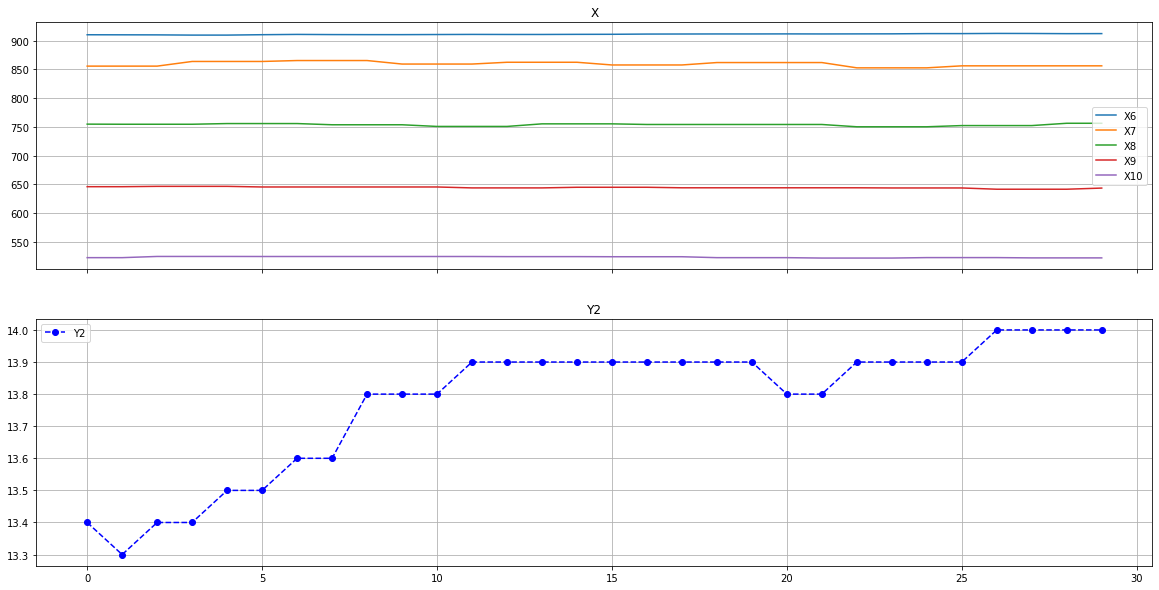

In [38]:
display_manager.displayPreditionDashboard()
content_manager.plotData()

前10個重要的特徵


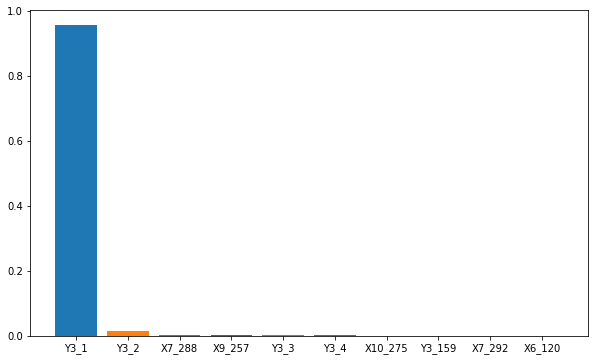

In [8]:
content_manager.showFeatureImportances()

In [9]:
content_manager.showTree()

圖太大了，畫不出來


In [ ]:
float_range_maplist = {}
def makeFloatRangeSlider(col_name):
    global float_range_maplist
    
    fr = widgets.FloatRangeSlider(
    value=[data[col_name].quantile(0.25), data[col_name].quantile(0.75)],
    min= data[col_name].min(),
    max= data[col_name].max(),
    step=0.1,
    description=col_name,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f')
    
    q_25 = np.round(data[col_name].quantile(0.25))
    q_75 = np.round(data[col_name].quantile(0.75))
    float_range_maplist[col_name] = np.array([
        randrange(q_25*10, q_75*10, step=1)/10 for _ in range(moving_window_size+test_period)
    ])
    
    return fr

In [ ]:
owner_ = None
def handle_slider_change(change):
    global owner_, float_range_maplist
    if change['name'] == '_property_lock' and len(change['new'].keys()) == 0:
        owner = change['owner']
        owner_ = owner
        float_range_maplist[owner_.description] = np.array(
            [randrange(
                np.round(owner_.value[0]*10), 
                np.round(owner_.value[1]*10), 
                step=1)/10 for _ in range(moving_window_size+test_period)]
        )
        #print('change: ', owner.description, 'value: ', owner.value)

        clear_output()
        displayRange()
        displayPlot()
        

def displayPlot():
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(20,10))
    ax1.set_title("X")
    for x_column in x_column_list:
        ax1.plot(float_range_maplist[x_column][-test_period:], label = x_column) 
    ax1.grid(True)
    ax1.legend()
    ax2.set_title(y_column)
    ax2.plot(float_range_maplist[y_column][-test_period:], label = y_column)
    ax2.grid(True)
    ax2.legend()
    plt.show()
    
def displayRange():
    display(X6_fr, output)
    display(X7_fr, output)
    display(X8_fr, output)
    display(X9_fr, output)
    display(X10_fr, output)
    display(Y_fr, output)
    
X6_fr = makeFloatRangeSlider('X6')
X7_fr = makeFloatRangeSlider('X7')
X8_fr = makeFloatRangeSlider('X8')
X9_fr = makeFloatRangeSlider('X9')
X10_fr = makeFloatRangeSlider('X10')
Y_fr = makeFloatRangeSlider(y_column)

X6_fr.observe(handle_slider_change)
X7_fr.observe(handle_slider_change)
X8_fr.observe(handle_slider_change)
X9_fr.observe(handle_slider_change)
X10_fr.observe(handle_slider_change)
Y_fr.observe(handle_slider_change)

In [ ]:
displayRange()
displayPlot()

In [ ]:
float_range_table = pd.DataFrame(float_range_maplist)

In [ ]:
for x_ in x_column_list:
    for log in range(moving_window_size+1):
        float_range_table["%s_%d"%(x_, log)] = float_range_table[x_].shift(log)

for log in range(1, moving_window_size+1):
    float_range_table["%s_%d"%(y_column, log)] = float_range_table[y_column].shift(log)

float_range_table = float_range_table.dropna()

In [ ]:
# feature_col = []
# for x_ in x_column_list:
#     for log in range(moving_window_size+1): 
#         feature_col.append("%s_%d"%(x_, log))
        
# for log in range(1, moving_window_size+1): 
#     feature_col.append("%s_%d"%(y_, log)) 

In [ ]:
val_y  = float_range_table[[y_column]]
val_x  = float_range_table[feature_col]

In [ ]:
test_prediction = model.predict(val_x.values)
plt.figure(figsize=(20,10))
plt.plot(val_y.values, color = 'b', label = y_column) 
plt.plot(test_prediction, color = 'red', label='pred') 
plt.xlabel("time")
plt.ylabel(y_column)
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [19]:
def on_button_clicked(b):
  # Display the message within the output widget.
  print("Button clicked.")

button = widgets.Button(description="Click Me!")
button.on_click(on_button_clicked)
display(button, output)

Button(description='Click Me!', style=ButtonStyle())

Output()